In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import fiona

def subset_points_within_polygon(kml_filename, df):
    # Enable KML support in Fiona (if your installation supports it)
    fiona.supported_drivers['KML'] = 'rw'
    
    # Read the KML file as a GeoDataFrame (assumes the polygon of interest is the first feature)
    gdf = gpd.read_file(kml_filename, driver='KML')
    polygon = gdf.geometry.iloc[0]
    
    # Create a geometry column from Lon/Lat in the DataFrame
    df = df.copy()  # work on a copy to avoid modifying the original DataFrame
    df['geometry'] = df.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
    
    # Subset the DataFrame to only include points within the polygon
    subset_df = df[df['geometry'].apply(lambda point: point.within(polygon))].copy()
    
    return subset_df


In [4]:
from pyproj import Proj, Transformer
import pandas as pd
import vtk
from vtk.util.numpy_support import numpy_to_vtk
import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
from io import BytesIO
from PIL import Image
import base64

# Load your catalog
df = pd.read_csv("NCEDC_complete_catalog.3693934.txt", skiprows = [1], delim_whitespace=True)

df = subset_points_within_polygon("AOI.kml", df)

# Define projection (use a UTM zone that includes your study area)
proj = Proj(proj='utm', zone=10, ellps='WGS84')  # e.g., UTM Zone 10 for SF Bay Area
transformer = Transformer.from_crs("EPSG:4326", proj.srs, always_xy=True)

# Convert Lon/Lat to Easting/Northing (in meters)
df["Easting"], df["Northing"] = transformer.transform(df["Lon"].values, df["Lat"].values)

# Convert depth from km to meters and invert sign (positive downward)
df["Depth_m"] = -df["Depth"] * 1000


# Create VTK points
points = vtk.vtkPoints()
magnitude_array = vtk.vtkFloatArray()
magnitude_array.SetName("Magnitude")

for _, row in df.iterrows():
    print(row["Easting"], row["Northing"], row["Depth_m"]) 
    points.InsertNextPoint(row["Easting"], row["Northing"], row["Depth_m"])
    magnitude_array.InsertNextValue(row["Mag"])

# Build polydata
polydata = vtk.vtkPolyData()
polydata.SetPoints(points)
polydata.GetPointData().AddArray(magnitude_array)
polydata.GetPointData().SetActiveScalars("Magnitude")

# Write to VTP
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName("double_difference_catalog_projected.vtp")
writer.SetInputData(polydata)
writer.Write()

print("Output saved as 'double_difference_catalog_projected.vtp'")


612039.1209963011 4115660.8335059606 -6188.0
625178.2275179247 4091783.695221621 -6605.0
595425.4823694725 4110074.6741611436 -11752.0
622522.2208332841 4093742.2745257174 -6275.0
621048.9932758755 4094109.479664826 -4633.0
620787.2582714041 4093736.2342732074 -4300.0
622158.0865251824 4093312.0229957476 -4610.0
614840.1380747102 4096797.099833459 -10729.0
617200.9411625016 4093389.611881154 -8524.0
597793.6278611867 4110175.045995296 -14473.0
597279.8205816057 4109818.47964281 -15480.0
596553.031729077 4109902.2176405694 -16519.0
612777.4874711398 4100264.64432199 -11867.0
620533.8215950329 4092715.087058092 -3071.0
612927.7245672281 4100137.9339803453 -12036.0
596518.3581600736 4109050.7908939677 -14298.0
619535.8784730698 4095105.5371174472 -7294.0
625894.2704958634 4091535.7428229833 -2725.0
625833.2552068284 4091626.9394565593 -2035.0000000000002
626725.9476032063 4088496.547289885 -4888.0
633507.9654455655 4087749.351841692 -3428.0
620662.9594995112 4093087.5435224534 -4021.0
622

In [8]:
from pyproj import Proj, Transformer
import pandas as pd
import vtk
from vtk.util.numpy_support import numpy_to_vtk
import numpy as np
import pyvista as pv
from io import BytesIO
from PIL import Image
import base64

# Read fixed-width formatted mechanism catalog
catalog = pd.read_fwf(
    "new_mechanisms.txt",
    colspecs=[
        (0, 4),    # Year
        (4, 8),    # MonthDay
        (9, 13),   # HourMinute
        (14, 19),  # OriginSeconds
        (20, 22),  # LatDeg
        (23, 28),  # LatMin
        (29, 32),  # LonDeg
        (33, 39),  # LonMin
        (40, 46),  # Depth
        (48, 52),  # Mag
        (83, 86),  # Strike
        (87, 89),  # Dip
        (89, 93),  # Rake
    ],
    header=None,
    names=[
        "Year", "MonthDay", "HourMinute", "OriginSeconds",
        "LatDeg", "LatMin", "LonDeg", "LonMin",
        "Depth", "Mag", "DipDirection", "Dip", "Rake"
    ]
)

# Convert to numeric
for col in ["LatDeg", "LatMin", "LonDeg", "LonMin", "Depth", "Mag", "DipDirection", "Dip", "Rake"]:
    catalog[col] = pd.to_numeric(catalog[col], errors="coerce")

# Compute decimal degrees
catalog["Lat"] = catalog["LatDeg"] + catalog["LatMin"] / 60
catalog["Lon"] = -(catalog["LonDeg"] + catalog["LonMin"] / 60)  # Western Hemisphere

catalog = subset_points_within_polygon("AOI.kml", catalog)

# Define projection (use a UTM zone that includes your study area)
proj = Proj(proj='utm', zone=10, ellps='WGS84')  # e.g., UTM Zone 10 for SF Bay Area
transformer = Transformer.from_crs("EPSG:4326", proj.srs, always_xy=True)

# Convert Lon/Lat to Easting/Northing (in meters)
catalog["Easting"], catalog["Northing"] = transformer.transform(catalog["Lon"].values, catalog["Lat"].values)

# Convert depth from km to meters and invert sign (positive downward)
catalog["Depth_m"] = -catalog["Depth"] * 1000

# Prepare output
output_df = catalog[["DipDirection", "Dip", "Rake", "Mag", "Easting", "Northing", "Depth_m"]].copy()
output_df.columns = ["dip_direction", "dip", "rake", "magnitude", "easting", "northing", "depth_m"]
output_df.dropna(inplace=True)


import numpy as np
import pyvista as pv

def rtp_to_tensor(strike, dip, rake):
    """
    Convert strike, dip, rake (in degrees) into a normalized double-couple moment tensor.
    The input angles follow standard seismological conventions (with strike measured
    clockwise from north, dip downward, and rake in the fault plane) in the N–E–Down system.
    
    Then the tensor is rotated into the ENU coordinate system (Easting, Northing, Elevation).
    """
    # Convert input angles to radians.
    strike = 0 #np.radians(strike)
    dip = 0 #np.radians(dip)
    rake = np.radians(rake)
    
    # Compute the moment tensor components in the N–E–Down system using standard formulas.
    mrr = -np.sin(dip) * np.cos(rake) * np.sin(2 * strike) - np.sin(2 * dip) * np.sin(rake) * (np.sin(strike))**2
    mtt =  np.sin(dip) * np.cos(rake) * np.sin(2 * strike) - np.sin(2 * dip) * np.sin(rake) * (np.cos(strike))**2
    mpp =  np.sin(2 * dip) * np.sin(rake)
    mrt = -np.sin(dip) * np.cos(rake) * np.cos(2 * strike) - 0.5 * np.sin(2 * dip) * np.sin(rake) * np.sin(2 * strike)
    mrp = -np.cos(dip) * np.cos(rake) * np.cos(strike) - np.cos(2 * dip) * np.sin(rake) * np.sin(strike)
    mtp = -np.cos(dip) * np.cos(rake) * np.sin(strike) + np.cos(2 * dip) * np.sin(rake) * np.cos(strike)
    
    # Assemble the symmetric moment tensor in the N–E–Down frame.
    # (Following the convention: M = [[mtt, -mtp, -mrt],
    #                                  [-mtp, mpp, -mrp],
    #                                  [-mrt, -mrp, mrr]])
    M = np.array([
        [mtt, -mtp, -mrt],
        [-mtp, mpp, -mrp],
        [-mrt, -mrp, mrr]
    ])
    
    # Rotate from the N–E–Down coordinate system to the ENU (Easting, Northing, Up) system.
    # In N–E–Down, X = North, Y = East, Z = Down. We want:
    #   X' = East, Y' = North, Z' = Up.
    # The rotation matrix below performs that conversion.
    R = np.array([
        [0, 1,  0],
        [1, 0,  0],
        [0, 0, -1]
    ])
    M_enu = R @ M @ R.T
    return M_enu


def radiation_pattern(M, directions):
    """
    For a moment tensor M and an array of unit direction vectors (Nx3),
    compute the scalar radiation pattern u = dᵀ M d for each direction.
    """
    u = np.einsum('...i,ij,...j->...', directions, M, directions)
    return u


def create_beachball_mesh(strike, dip, rake, center, scale=1.0, resolution=100):
    """
    Create a beach ball mesh (as a PyVista PolyData) for a given focal mechanism.
    
    The procedure is:
      1. Compute the moment tensor from (strike, dip, rake) using rtp_to_tensor.
      2. Create a unit sphere (centered at the origin).
      3. For each point on the sphere, compute the radiation pattern u = dᵀ M d.
         Points with u >= 0 are labeled as +1 (compressional, to be colored black),
         and points with u < 0 as -1 (dilational, to be colored white).
      4. The mesh is then rotated to align with the fault plane:
         - A preliminary rotation of -90° about Z is applied (to set a reference orientation),
         - then a rotation about Z by the fault strike,
         - and finally a rotation about X by the fault dip.
      5. Finally, the mesh is scaled and translated to its proper location.
      
    The final mesh is in ENU coordinates (Easting, Northing, Elevation).
    """
    # Step 1: Compute the moment tensor (in ENU).
    M = rtp_to_tensor(strike, dip, rake)
    
    # Step 2: Create a unit sphere.
    sphere = pv.Sphere(radius=1.0, theta_resolution=resolution, phi_resolution=resolution)
    # Normalize sphere points to get unit direction vectors.
    directions = sphere.points / np.linalg.norm(sphere.points, axis=1)[:, np.newaxis]
    
    # Step 3: Compute the radiation pattern on the sphere.
    amplitudes = radiation_pattern(M, directions)
    
    # Step 4: Create a binary scalar field for the lobes.
    lobe_type = np.where(amplitudes >= 0, 1, -1)
    mesh = pv.PolyData(sphere.points, sphere.faces)
    mesh["lobe_type"] = lobe_type
    
    # Step 5: Rotate the mesh to orient it with the fault plane.
    # The fault's strike is computed externally (see export_beachballs below) from dip_direction.
    # The following rotations are applied in order:
    #   (a) Rotate by -90° about Z to set a baseline orientation.
    #   (b) Rotate by 'strike' about Z to orient horizontally.
    #   (c) Rotate by 'dip' about X to tilt the plane.
    #mesh.rotate_x(dip, point=(0, 0, 0), inplace=True)
    mesh.rotate_y(90, point=(0, 0, 0), inplace=True)
    mesh.rotate_x(dip, point=(0, 0, 0), inplace=True)
    mesh.rotate_z(90-strike, point=(0, 0, 0), inplace=True) 

    # Step 6: Scale the sphere by the given factor and translate to the event location.
    mesh.scale([scale, scale, scale], inplace=True)
    mesh.translate(center, inplace=True)
    
    return mesh


def export_beachballs(df, num_beachballs=None, output_path="focal_mechanisms.vtp",
                      scale_factor=1, min_magnitude=None):
    """
    Export beach ball meshes from a DataFrame containing focal mechanism data.
    
    The DataFrame is expected to have the following columns:
      - 'dip_direction': the azimuth (in degrees) toward which the fault dips.
      - 'dip', 'rake', 'magnitude', 'easting', 'northing', 'depth_m'.
      
    The fault strike is computed as (dip_direction - 90) mod 360.
    
    Optionally, you can filter by a minimum magnitude or limit the number of beach balls.
    The final meshes are merged and saved as a .vtp file (or as .vtu if merging fails).
    """
    # Filter by minimum magnitude if provided.
    if min_magnitude is not None:
        df = df[df["magnitude"] >= min_magnitude]
    if num_beachballs is not None:
        df = df.iloc[:num_beachballs]
    
    meshes = []
    for idx, row in df.iterrows():
        # Compute the fault strike from the dip_direction.
        # (Assuming dip_direction is the azimuth toward which the plane dips.)
        strike = (row["dip_direction"] - 90) % 360
        dip = row["dip"]
        rake = row["rake"]
        mag = row["magnitude"]
        pos = (row["easting"], row["northing"], row["depth_m"])
        
        mesh = create_beachball_mesh(
            strike=strike,
            dip=dip,
            rake=rake,
            center=pos,
            scale=mag * scale_factor
        )
        meshes.append(mesh)
    
    # Merge the individual meshes into one and save as a .vtp file.
    try:
        combined = meshes[0]
        for m in meshes[1:]:
            combined = combined.merge(m)
        if not output_path.endswith(".vtp"):
            output_path = output_path.rsplit(".", 1)[0] + ".vtp"
        combined.save(output_path)
        print(f"✅ Exported {len(df)} beach balls to: {output_path} (PolyData)")
    except Exception as e:
        print("⚠️ Could not merge as PolyData; saving as UnstructuredGrid (.vtu) instead.")
        combined = pv.MultiBlock(meshes).combine()
        output_path = output_path.rsplit(".", 1)[0] + ".vtu"
        combined.save(output_path)
        print(f"✅ Exported {len(df)} beach balls to: {output_path} (UnstructuredGrid)")


In [10]:
import pandas as pd
export_beachballs(output_df, num_beachballs=None, min_magnitude = 3, scale_factor = 100)


✅ Exported 133 beach balls to: focal_mechanisms.vtp (PolyData)


In [ ]:

example_df = pd.DataFrame([{
    "dip_direction": 135,     
    "dip": 30,             
    "rake": 90,            
    "magnitude": 5.5,         # Moderate event
    "easting": 551000.0,
    "northing": 4182000.0,
    "depth_m": -8000.0
}])

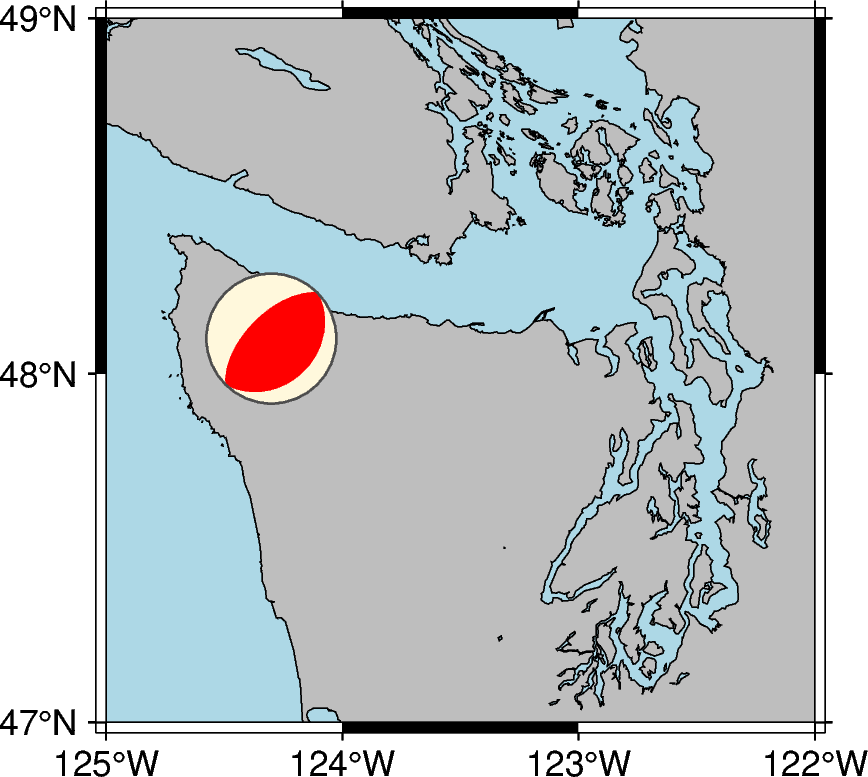

In [121]:
# Check:

import pygmt

fig = pygmt.Figure()

# Generate a map near Washington State showing land, water, and shorelines
fig.coast(
    region=[-125, -122, 47, 49],
    projection="M6c",
    land="grey",
    water="lightblue",
    shorelines=True,
    frame="a",
)

# Store focal mechanism parameters in a dictionary based on the Aki & Richards
# convention
focal_mechanism = {"strike": example_df["dip_direction"]-90, "dip": example_df["dip"], "rake": example_df["rake"], "magnitude": example_df["magnitude"]}

# Pass the focal mechanism data through the spec parameter. In addition provide
# scale, event location, and event depth
fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=-124.3,
    latitude=48.1,
    depth=12.0,
    # Fill compressive quadrants with color "red"
    # [Default is "black"]
    compressionfill="red",
    # Fill extensive quadrants with color "cornsilk"
    # [Default is "white"]
    extensionfill="cornsilk",
    # Draw a 0.5 points thick dark gray ("gray30") solid outline via
    # the pen parameter [Default is "0.25p,black,solid"]
    pen="0.5p,gray30,solid",
)

fig.show()



### Note: The GMT figure is a lower-hemisphere projection, which is not possible in 3D.  Thus, instead of looking at the bottom of the hemisphere, we are looking at the surface of the focal mechanism, which is why it appears that the mechanism is reversed.

In [25]:
from osgeo import gdal
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy
from PIL import Image

def generate_draped_topography(dem_tif, rgb_tif, output_vts="topography_uv_warped.vts", output_png="geologic_map_rgb.png", vertical_scale = 1.0):
    # --- Load DEM ---
    dem_ds = gdal.Open(dem_tif)
    dem_band = dem_ds.GetRasterBand(1)
    elevation = dem_band.ReadAsArray().astype(np.float32)
    nodata = dem_band.GetNoDataValue()
    if nodata is not None:
        elevation = np.ma.masked_equal(elevation, nodata).filled(0)

    n_rows, n_cols = elevation.shape
    gt = dem_ds.GetGeoTransform()
    x_origin, y_origin = gt[0], gt[3]
    pixel_width, pixel_height = gt[1], abs(gt[5])

    # --- Build structured grid points at z=0 ---
    points = vtk.vtkPoints()
    for j in range(n_rows):
        for i in range(n_cols):
            x = x_origin + i * pixel_width
            y = y_origin - j * pixel_height  # Note: GDAL Y origin is upper-left
            z = 0
            points.InsertNextPoint(x, y, z)

    # --- Build StructuredGrid and set dimensions ---
    grid = vtk.vtkStructuredGrid()
    grid.SetDimensions(n_cols, n_rows, 1)
    grid.SetPoints(points)

    # --- Attach Elevation Scalars and Warp ---
    elev_flat = elevation.ravel(order="C")  # StructuredGrid uses C-order
    vtk_elev = numpy_to_vtk(elev_flat, deep=True, array_type=vtk.VTK_FLOAT)
    vtk_elev.SetName("Elevation")
    grid.GetPointData().SetScalars(vtk_elev)

    warped_points = vtk.vtkPoints()
    for i in range(points.GetNumberOfPoints()):
        x, y, _ = points.GetPoint(i)
        z = elev_flat[i]*vertical_scale
        warped_points.InsertNextPoint(x, y, z)
    grid.SetPoints(warped_points)

    # --- Load RGB GeoTIFF and extract texture bounds ---
    rgb_ds = gdal.Open(rgb_tif)
    r = rgb_ds.GetRasterBand(1).ReadAsArray()
    g = rgb_ds.GetRasterBand(2).ReadAsArray()
    b = rgb_ds.GetRasterBand(3).ReadAsArray()

    rgb_gt = rgb_ds.GetGeoTransform()
    rgb_x_min = rgb_gt[0]
    rgb_y_max = rgb_gt[3]
    rgb_pixel_width = rgb_gt[1]
    rgb_pixel_height = abs(rgb_gt[5])
    rgb_x_max = rgb_x_min + rgb_ds.RasterXSize * rgb_pixel_width
    rgb_y_min = rgb_y_max - rgb_ds.RasterYSize * rgb_pixel_height

    # --- Export RGB image as PNG ---
    rgb_stack = np.dstack((r, g, b)).astype(np.uint8)
    rgb_image = Image.fromarray(rgb_stack)
    rgb_image.save(output_png)

    # --- Assign Texture Coordinates (UVs) ---
    uv_array = vtk.vtkFloatArray()
    uv_array.SetNumberOfComponents(2)
    uv_array.SetName("TextureCoordinates")

    for i in range(grid.GetNumberOfPoints()):
        x, y, _ = warped_points.GetPoint(i)
        if rgb_x_min <= x <= rgb_x_max and rgb_y_min <= y <= rgb_y_max:
            u = (x - rgb_x_min) / (rgb_x_max - rgb_x_min)
            v = (y - rgb_y_min) / (rgb_y_max - rgb_y_min)
        else:
            u = v = -1  # Outside bounds
        uv_array.InsertNextTuple((u, v))

    grid.GetPointData().SetTCoords(uv_array)

    # --- Write final warped and textured grid ---
    writer = vtk.vtkXMLStructuredGridWriter()
    writer.SetFileName(output_vts)
    writer.SetInputData(grid)
    writer.Write()

    print(f"✅ Saved warped structured grid: {output_vts}")
    print(f"✅ Saved RGB texture image:      {output_png}")


In [26]:
generate_draped_topography(
    dem_tif="FFTBDEM_utm.tif",
    rgb_tif="merged_map_final.tif",
    output_vts="topography_uv_warped.vts",
    output_png="geologic_map_rgb.png",
    vertical_scale = 2.0
)

✅ Saved warped structured grid: topography_uv_warped.vts
✅ Saved RGB texture image:      geologic_map_rgb.png


In [1]:
import numpy as np
from osgeo import gdal
from PIL import Image
import vtk
from vtk.util.numpy_support import numpy_to_vtk

def affine_from_points(img_pts, world_pts):
    """
    Solve for affine transform: [x y z] = [u v 1] @ A
    img_pts: (N,2) array of pixel (u,v)
    world_pts: (N,3) array of (x,y,z)
    """
    N = img_pts.shape[0]
    A = np.hstack([img_pts, np.ones((N, 1))])  # (N, 3)
    B = world_pts  # (N, 3)
    X, _, _, _ = np.linalg.lstsq(A, B, rcond=None)  # (3, 3)
    return X.T  # So that: world = [u v 1] @ A.T

def generate_cross_section_affine(rgb_tif, control_points, output_vtp, output_png):
    # Load image
    ds = gdal.Open(rgb_tif)
    r = ds.GetRasterBand(1).ReadAsArray()
    g = ds.GetRasterBand(2).ReadAsArray()
    b = ds.GetRasterBand(3).ReadAsArray()
    height, width = r.shape

    # Save as PNG
    rgb_stack = np.dstack((r, g, b)).astype(np.uint8)
    Image.fromarray(rgb_stack).save(output_png)

    # Parse control points
    img_pts = np.array([(pt[0], pt[1]) for pt in control_points])
    world_pts = np.array([(pt[2], pt[3], pt[4]) for pt in control_points])

    # Compute affine transform
    A = affine_from_points(img_pts, world_pts)

    # Build point grid
    points = vtk.vtkPoints()
    tcoords = vtk.vtkFloatArray()
    tcoords.SetNumberOfComponents(2)
    tcoords.SetName("TextureCoordinates")

    for j in range(height):
        for i in range(width):
            uv1 = np.array([i, j, 1.0])
            xyz = A @ uv1
            points.InsertNextPoint(*xyz)
            tcoords.InsertNextTuple((i / (width - 1), 1.0 - j / (height - 1)))  # V flipped

    # Create quads
    polys = vtk.vtkCellArray()
    for j in range(height - 1):
        for i in range(width - 1):
            id0 = j * width + i
            id1 = id0 + 1
            id2 = id1 + width
            id3 = id0 + width
            quad = vtk.vtkQuad()
            quad.GetPointIds().SetId(0, id0)
            quad.GetPointIds().SetId(1, id1)
            quad.GetPointIds().SetId(2, id2)
            quad.GetPointIds().SetId(3, id3)
            polys.InsertNextCell(quad)

    # Assemble PolyData
    poly = vtk.vtkPolyData()
    poly.SetPoints(points)
    poly.SetPolys(polys)
    poly.GetPointData().SetTCoords(tcoords)

    # Write to VTP
    writer = vtk.vtkXMLPolyDataWriter()
    writer.SetFileName(output_vtp)
    writer.SetInputData(poly)
    writer.Write()

    print(f"✅ Cross-section surface saved to: {output_vtp}")
    print(f"✅ Texture image saved to: {output_png}")

In [3]:
# clipped_a_san_mateo

filename_prefix = 'CrossSections/clipped_a_san_mateo'

control_points = [
    (0, 0, 542205, 4158656, 487.68),
    (0, 381, 542205, 4158656, -365.76), # image (X,Y) → real-world (x,y,z)
    (4353, 381, 548895, 4164334, -365.76),
    (4353, 0, 548895, 4164334, 487.68),
]

generate_cross_section_affine(
    rgb_tif="{0}.tif".format(filename_prefix),
    control_points=control_points,
    output_vtp="{0}.vtp".format(filename_prefix),
    output_png="{0}.png".format(filename_prefix)
)

✅ Cross-section surface saved to: CrossSections/clipped_a_san_mateo.vtp
✅ Texture image saved to: CrossSections/clipped_a_san_mateo.png


In [5]:
# clipped_b_san_mateo

filename_prefix = 'CrossSections/clipped_b_san_mateo'




control_points = [
    (0,	0,	542629,	4155237,	487.68,	1600),
    (0,	373,	542629,	4155237,	-365.76,	-1200), # image (X,Y) → real-world (x,y,z)
    (6298,	373,	551554,	4164355,	-365.76,	-1200),
    (6298,	0,	551554,	4164355,	487.68,	1600),
]

generate_cross_section_affine(
    rgb_tif="{0}.tif".format(filename_prefix),
    control_points=control_points,
    output_vtp="{0}.vtp".format(filename_prefix),
    output_png="{0}.png".format(filename_prefix)
)

✅ Cross-section surface saved to: CrossSections/clipped_b_san_mateo.vtp
✅ Texture image saved to: CrossSections/clipped_b_san_mateo.png
